In [17]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import requests  

In [2]:
# Configuración inicial
client = bigquery.Client()

query = """
SELECT *  # Selecciona todas las columnas
FROM `bigquery-public-data.noaa_gsod.gsod2024`  # Tabla completa
WHERE date BETWEEN '2024-01-01' AND '2024-12-31'
"""

# Ejecutar (puede ser lento y costoso con tablas grandes)
df_full = client.query(query).to_dataframe()

C:\Users\jsanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
df_full.head()

,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,010020,99999,2024-12-31,2024,12,31,13.3,4,6.4,4,...,*,0.0,I,999.9,0,0,0,0,0,0
1,010090,99999,2024-04-16,2024,04,16,-3.1,4,9999.9,0,...,None,0.0,I,999.9,0,0,0,0,0,0
2,010160,99999,2024-10-30,2024,10,30,26.1,4,22.2,4,...,None,0.0,I,999.9,0,0,0,0,0,0
3,010170,99999,2024-03-08,2024,03,08,30.9,4,30.5,4,...,None,0.0,I,999.9,0,0,0,0,0,0
4,010200,99999,2024-12-10,2024,12,10,22.5,4,18.8,4,...,None,0.0,I,999.9,0,0,0,0,0,0


In [4]:
df_full.drop(columns=[ "wban","year","stn","flag_prcp", "flag_min", "slp", "count_visib", "count_wdsp", "flag_max", "da", "count_temp", "dewp", "count_dewp", "count_slp", "stp", "sndp", "gust", "mxpsd", "count_stp"], inplace=True) # Se eliminan las columnas que no entregan infrormación relevante

In [5]:
df_full = df_full.rename(columns={'date':'Fecha'}) # cambiamos el nombre de la columna "date" a "Fecha"
df_full = df_full.rename(columns={'mo':'mes'}) # cambiamos el nombre de la columna "date" a "Fecha"

In [6]:
df_full.head()

,Fecha,mes,temp,visib,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,2024-12-31,12,13.3,999.9,16.4,14.5,12.7,0.0,0,0,0,0,0,0
1,2024-04-16,04,-3.1,999.9,2.9,7.2,-11.7,0.0,0,0,0,0,0,0
2,2024-10-30,10,26.1,999.9,8.7,28.0,25.2,0.0,0,0,0,0,0,0
3,2024-03-08,03,30.9,999.9,5.3,32.4,29.8,0.0,0,0,0,0,0,0
4,2024-12-10,12,22.5,999.9,18.0,24.1,20.5,0.0,0,0,0,0,0,0


In [7]:
print(df_full['Fecha'].dtype) # Mostrar el tipo de dato de la columna Fecha

dbdate


In [8]:
df_full['Fecha'] = pd.to_datetime(df_full['Fecha']) # Convertir la columna Fecha a tipo datetime

In [9]:
# Asegúrate de que la columna con la temperatura en Fahrenheit existe en el DataFrame
# Reemplaza 'temperature_fahrenheit' con el nombre real de la columna
df_full['Temperatura ºC'] = (df_full['temp'] - 32) * 5 / 9

# Verificar los primeros registros para asegurarte de que la conversión se realizó correctamente
print(df_full[['Fecha', 'Temperatura ºC', 'temp']].head())


       Fecha  Temperatura ºC  temp
0 2024-12-31      -10.388889  13.3
1 2024-04-16      -19.500000  -3.1
2 2024-10-30       -3.277778  26.1
3 2024-03-08       -0.611111  30.9
4 2024-12-10       -5.277778  22.5


In [10]:
df_bq_ordenado = df_full.sort_values('Fecha', ascending=True).reset_index(drop=True) # Ordenar los datos por fecha y reorganizar los indices

In [11]:
df_bq_ordenado.head() # Mostrar los primeros 5 registros para corroborar que se haya ordenado correctamente

,Fecha,mes,temp,visib,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,Temperatura ºC
0,2024-01-01,01,35.6,10.0,7.0,37.9,34.0,0.00,0,0,0,0,0,0,2.000000
1,2024-01-01,01,33.9,12.4,2.5,47.1,16.9,0.00,0,0,0,0,0,0,1.055556
2,2024-01-01,01,24.3,10.0,4.8,26.6,23.0,0.00,0,0,0,0,0,0,-4.277778
3,2024-01-01,01,18.8,9.4,5.4,28.0,14.0,0.00,0,0,1,0,0,0,-7.333333
4,2024-01-01,01,66.4,999.9,10.1,71.8,55.0,0.28,0,1,0,0,0,0,19.111111


In [12]:
df_bq_ordenado.tail() # Mostrar los últimos 5 registros para corroborar que se haya ordenado correctamente

,Fecha,mes,temp,visib,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,Temperatura ºC
3858309,2024-12-31,12,31.2,7.5,4.9,32.4,28.8,99.99,1,0,1,0,0,0,-0.444444
3858310,2024-12-31,12,24.8,8.1,1.1,31.8,19.8,0.05,0,0,1,0,0,0,-4.000000
3858311,2024-12-31,12,51.5,999.9,13.4,54.5,49.3,0.00,0,0,0,0,0,0,10.833333
3858312,2024-12-31,12,46.0,10.0,4.1,55.0,42.1,0.70,0,0,0,0,0,0,7.777778
3858313,2024-12-31,12,13.3,999.9,16.4,14.5,12.7,0.00,0,0,0,0,0,0,-10.388889


In [13]:
promedio = df_bq_ordenado['Temperatura ºC'].mean() # Calcular la temperatura promedio
# Mostrar la temperatura promedio
print("La temperatura promedio es:", promedio, "ºC")

La temperatura promedio es: 13.869136176521081 ºC


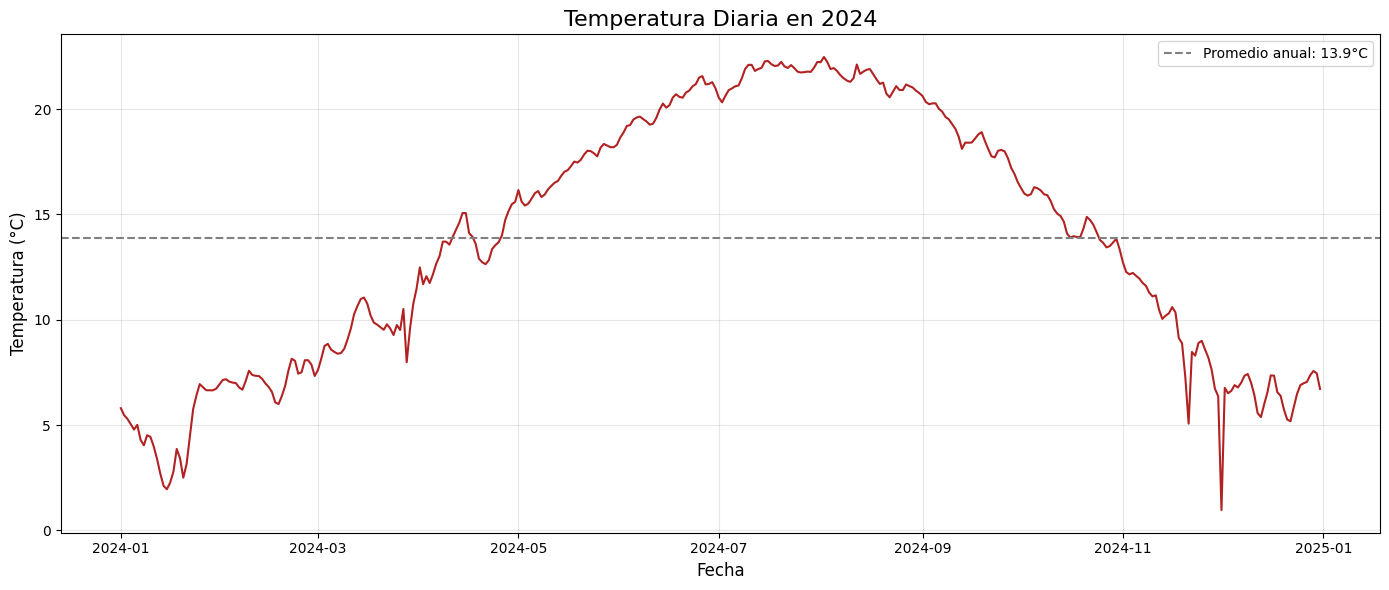

In [14]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_bq_ordenado, 
    x='Fecha', 
    y='Temperatura ºC', 
    estimator='mean', 
    errorbar=None,
    color='firebrick'
)
# Personalización del gráfico
plt.title(f'Temperatura Diaria en 2024', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.grid(alpha=0.3)
# Línea de promedio anual (usando el valor calculado)
plt.axhline(y=promedio, 
            color='gray', 
            linestyle='--', 
            linewidth=1.5,
            label=f'Promedio anual: {promedio:.1f}°C')

plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

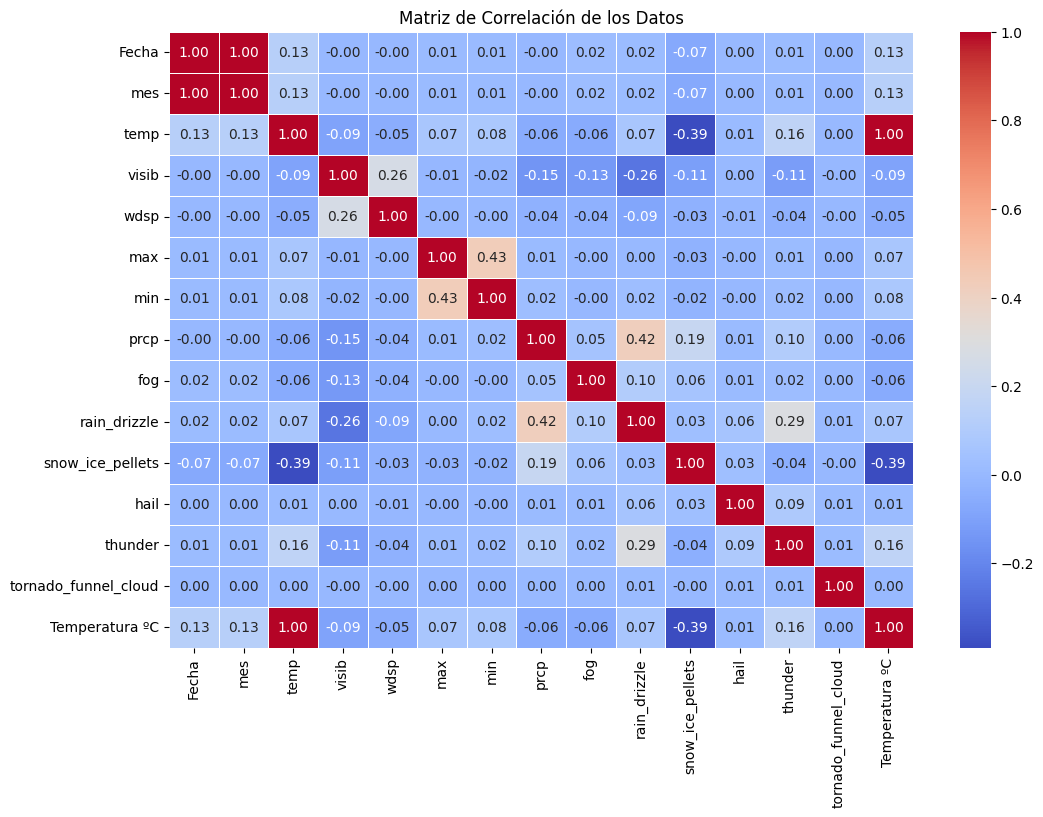

In [15]:
# Calcular la matriz de correlación
correlation_matrix = df_bq_ordenado.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlación de los Datos")
plt.show()


In [18]:
# URL de la API
url = "https://power.larc.nasa.gov/api/temporal/hourly/point"

# Parámetros de la consulta
params = {
    'start': '20240101',
    'end': '20241231',
    'latitude': 40,
    'longitude': -100,
    'community': 'ag',
    'parameters': 'T2M,RH2M,WS2M,WD2M,PRECTOTCORR,CLOUD_AMT,QV2M',
    'header': 'true',
    'format': 'json'
}

# Encabezados
headers = {
    'accept': 'application/json'
}

# Hacer la solicitud GET
response = requests.get(url, params=params, headers=headers)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    # Convertir la respuesta a JSON
    data = response.json()
    
    # Extraer los datos horarios (ajusta según la estructura real de la respuesta)
    hourly_data = data['properties']['parameter']
    
    # Convertir a DataFrame de pandas
    df = pd.DataFrame.from_dict(hourly_data)
    
    # Mostrar las primeras filas
    print(df.head())
    
    # Opcional: Guardar en CSV
    df.to_csv('nasa_power_data.csv', index=False)
else:
    print(f"Error en la solicitud: {response.status_code}")
    print(response.text)

             T2M   RH2M  WS2M   WD2M  PRECTOTCORR  CLOUD_AMT  QV2M
2024010100 -5.35  96.87  0.83  191.9          0.0      18.89  2.50
2024010101 -5.30  96.85  1.08  204.0          0.0      14.88  2.51
2024010102 -5.19  96.30  1.20  211.7          0.0      42.50  2.52
2024010103 -5.08  95.73  1.22  216.7          0.0      63.33  2.53
2024010104 -4.97  95.17  1.31  219.4          0.0      84.90  2.54


In [19]:
df # Mostrar los primeros registros del DataFrame

,T2M,RH2M,WS2M,WD2M,PRECTOTCORR,CLOUD_AMT,QV2M
2024010100,-5.35,96.87,0.83,191.9,0.0,18.89,2.50
2024010101,-5.30,96.85,1.08,204.0,0.0,14.88,2.51
2024010102,-5.19,96.30,1.20,211.7,0.0,42.50,2.52
2024010103,-5.08,95.73,1.22,216.7,0.0,63.33,2.53
2024010104,-4.97,95.17,1.31,219.4,0.0,84.90,2.54
...,...,...,...,...,...,...,...
2024123119,-1.94,56.81,0.81,26.2,0.0,-999.00,1.96
2024123120,-1.98,55.57,0.60,18.4,0.0,-999.00,1.91
2024123121,-2.04,57.34,0.52,322.0,0.0,-999.00,1.96
2024123122,-2.48,60.73,0.77,288.2,0.0,-999.00,2.00


In [20]:
# 1. Convertir el diccionario a DataFrame
df = pd.DataFrame.from_dict(hourly_data)

# 2. Convertir el índice a datetime y luego a fecha (sin hora)
df.index = pd.to_datetime(df.index, format='%Y%m%d%H').date  # <-- .date elimina la hora

# 3. Resetear índice (opcional, si quieres columna separada)
df = df.reset_index().rename(columns={'index': 'fecha'})

# Verificación
print(df.head())

        fecha   T2M   RH2M  WS2M   WD2M  PRECTOTCORR  CLOUD_AMT  QV2M
0  2024-01-01 -5.35  96.87  0.83  191.9          0.0      18.89  2.50
1  2024-01-01 -5.30  96.85  1.08  204.0          0.0      14.88  2.51
2  2024-01-01 -5.19  96.30  1.20  211.7          0.0      42.50  2.52
3  2024-01-01 -5.08  95.73  1.22  216.7          0.0      63.33  2.53
4  2024-01-01 -4.97  95.17  1.31  219.4          0.0      84.90  2.54


In [21]:
df

,fecha,T2M,RH2M,WS2M,WD2M,PRECTOTCORR,CLOUD_AMT,QV2M
0,2024-01-01,-5.35,96.87,0.83,191.9,0.0,18.89,2.50
1,2024-01-01,-5.30,96.85,1.08,204.0,0.0,14.88,2.51
2,2024-01-01,-5.19,96.30,1.20,211.7,0.0,42.50,2.52
3,2024-01-01,-5.08,95.73,1.22,216.7,0.0,63.33,2.53
4,2024-01-01,-4.97,95.17,1.31,219.4,0.0,84.90,2.54
...,...,...,...,...,...,...,...,...
8779,2024-12-31,-1.94,56.81,0.81,26.2,0.0,-999.00,1.96
8780,2024-12-31,-1.98,55.57,0.60,18.4,0.0,-999.00,1.91
8781,2024-12-31,-2.04,57.34,0.52,322.0,0.0,-999.00,1.96
8782,2024-12-31,-2.48,60.73,0.77,288.2,0.0,-999.00,2.00


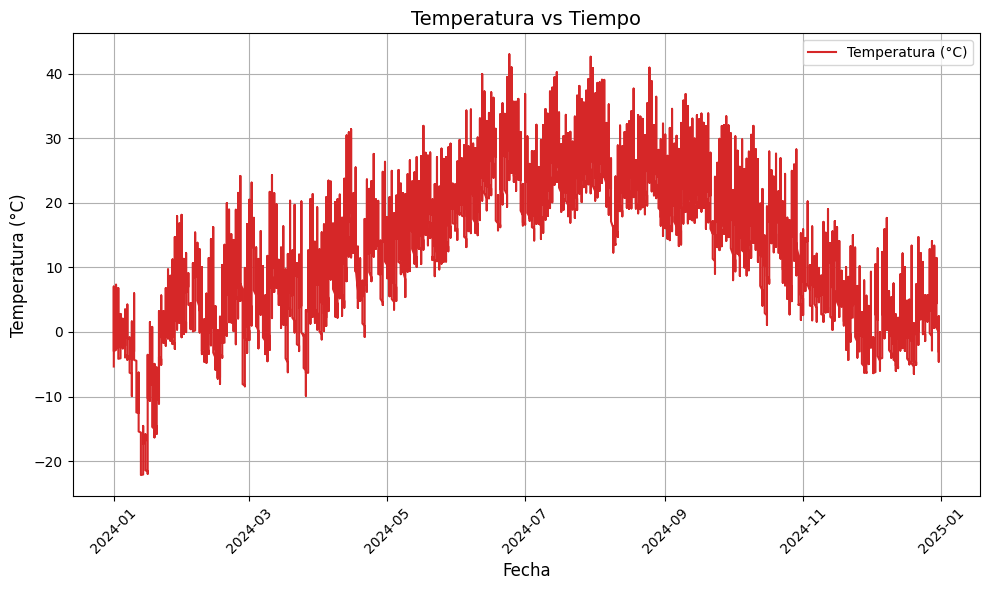

In [22]:
# Graficar la temperatura vs tiempo
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['T2M'], label='Temperatura (°C)', color='tab:red')
plt.title('Temperatura vs Tiempo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


Columnas disponibles: ['fecha', 'T2M', 'RH2M', 'WS2M', 'WD2M', 'PRECTOTCORR', 'CLOUD_AMT', 'QV2M']

Correlaciones más fuertes:
T2M   QV2M    0.776185
QV2M  T2M     0.776185
T2M   RH2M   -0.510991
RH2M  T2M    -0.510991
dtype: float64


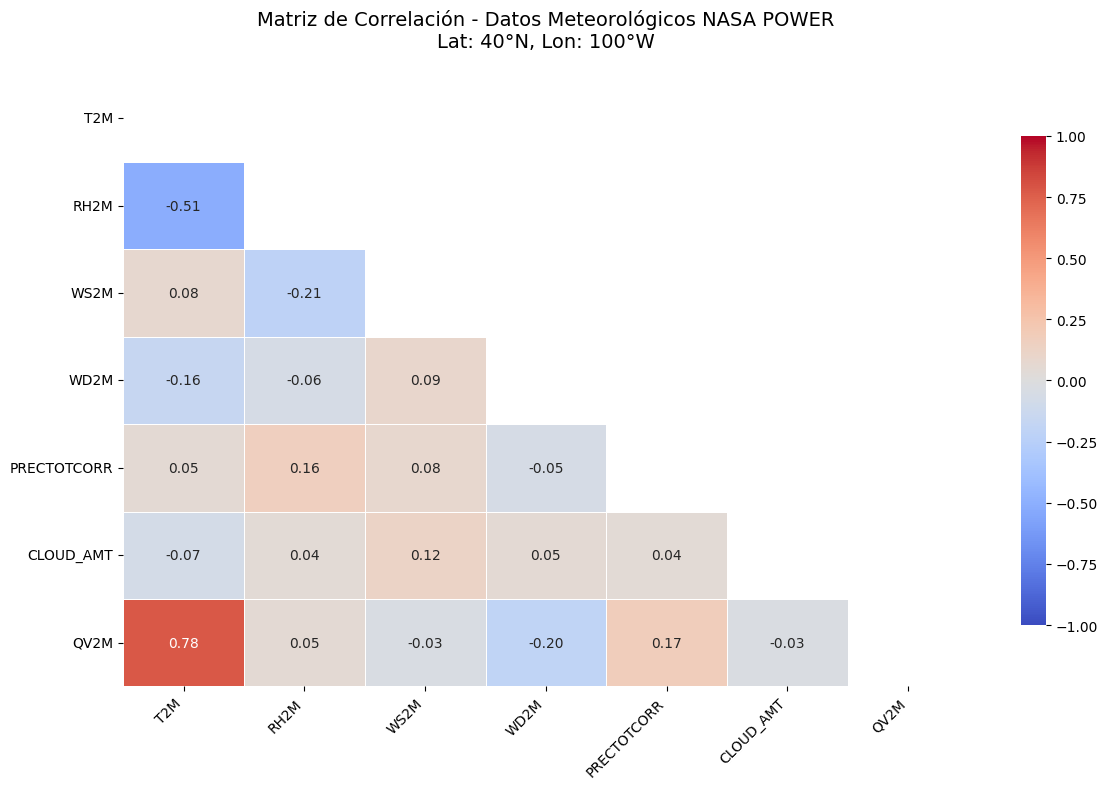

In [23]:
# Verificar las columnas disponibles
print("Columnas disponibles:", df.columns.tolist())

# 2. Seleccionar solo variables numéricas continuas
# (Excluyendo códigos de fecha/hora si existen)
columnas_numericas = ['T2M', 'RH2M', 'WS2M', 'WD2M', 'PRECTOTCORR', 'CLOUD_AMT', 'QV2M']
df_numerico = df[columnas_numericas]

# 3. Calcular matriz de correlación
corr_matrix = df_numerico.corr()

# 4. Visualización mejorada
plt.figure(figsize=(12, 8))

# Crear máscara para mostrar solo la mitad inferior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap con seaborn
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, 
            vmax=1,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

# Personalización
plt.title('Matriz de Correlación - Datos Meteorológicos NASA POWER\nLat: 40°N, Lon: 100°W', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# 5. Análisis adicional
print("\nCorrelaciones más fuertes:")
corr_unstack = corr_matrix.unstack().sort_values(ascending=False)
print(corr_unstack[(abs(corr_unstack) > 0.5) & (abs(corr_unstack) < 1.0)])

plt.show()


<Figure size 1600x600 with 0 Axes>

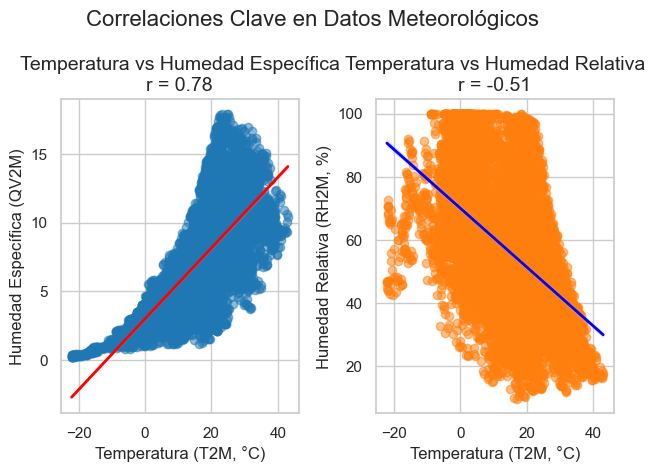

In [24]:
# Configuración del estilo (corregido)
sns.set_theme(style="whitegrid")  # Usando el tema de Seaborn directamente
plt.figure(figsize=(16, 6))

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Gráfico 1: T2M vs QV2M (correlación positiva)
sns.regplot(data=df, x='T2M', y='QV2M', ax=ax1,
            scatter_kws={'alpha':0.5, 'color':'#1f77b4'},
            line_kws={'color':'red', 'linewidth':2})
ax1.set_title('Temperatura vs Humedad Específica\nr = 0.78', fontsize=14)
ax1.set_xlabel('Temperatura (T2M, °C)')
ax1.set_ylabel('Humedad Específica (QV2M)')

# Gráfico 2: T2M vs RH2M (correlación negativa)
sns.regplot(data=df, x='T2M', y='RH2M', ax=ax2,
            scatter_kws={'alpha':0.5, 'color':'#ff7f0e'},
            line_kws={'color':'blue', 'linewidth':2})
ax2.set_title('Temperatura vs Humedad Relativa\nr = -0.51', fontsize=14)
ax2.set_xlabel('Temperatura (T2M, °C)') 
ax2.set_ylabel('Humedad Relativa (RH2M, %)')

# Ajustes finales
plt.suptitle('Correlaciones Clave en Datos Meteorológicos', fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# Asegúrate de que la columna 'date' esté en formato datetime
df_bq_ordenado['Fecha'] = pd.to_datetime(df_bq_ordenado['Fecha'])

# Suponiendo que los datos de la API están en 'df_api' y también tienen una columna 'Fecha' (ajusta el nombre según tu DataFrame)
df['Fecha'] = pd.to_datetime(df['fecha'])

# Ahora, puedes realizar el merge (unión) de los dos DataFrames utilizando la columna de fechas
df_combined = pd.merge(df_bq_ordenado, df, left_on='Fecha', right_on='Fecha', how='left')

# Ver los primeros datos combinados
print(df_combined.head())

       Fecha mes  temp  visib wdsp   max   min  prcp fog rain_drizzle  ...  \
0 2024-01-01  01  35.6   10.0  7.0  37.9  34.0   0.0   0            0  ...   
1 2024-01-01  01  35.6   10.0  7.0  37.9  34.0   0.0   0            0  ...   
2 2024-01-01  01  35.6   10.0  7.0  37.9  34.0   0.0   0            0  ...   
3 2024-01-01  01  35.6   10.0  7.0  37.9  34.0   0.0   0            0  ...   
4 2024-01-01  01  35.6   10.0  7.0  37.9  34.0   0.0   0            0  ...   

  tornado_funnel_cloud Temperatura ºC       fecha   T2M   RH2M  WS2M   WD2M  \
0                    0            2.0  2024-01-01 -5.35  96.87  0.83  191.9   
1                    0            2.0  2024-01-01 -5.30  96.85  1.08  204.0   
2                    0            2.0  2024-01-01 -5.19  96.30  1.20  211.7   
3                    0            2.0  2024-01-01 -5.08  95.73  1.22  216.7   
4                    0            2.0  2024-01-01 -4.97  95.17  1.31  219.4   

   PRECTOTCORR  CLOUD_AMT  QV2M  
0          0.0      18

In [26]:
df_combined.drop(columns=[ "fecha", "temp"], inplace=True) # Se eliminan las columnas que no entregan infrormación relevante

In [27]:
df_combined.head()

,Fecha,mes,visib,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,...,thunder,tornado_funnel_cloud,Temperatura ºC,T2M,RH2M,WS2M,WD2M,PRECTOTCORR,CLOUD_AMT,QV2M
0,2024-01-01,01,10.0,7.0,37.9,34.0,0.0,0,0,0,...,0,0,2.0,-5.35,96.87,0.83,191.9,0.0,18.89,2.50
1,2024-01-01,01,10.0,7.0,37.9,34.0,0.0,0,0,0,...,0,0,2.0,-5.30,96.85,1.08,204.0,0.0,14.88,2.51
2,2024-01-01,01,10.0,7.0,37.9,34.0,0.0,0,0,0,...,0,0,2.0,-5.19,96.30,1.20,211.7,0.0,42.50,2.52
3,2024-01-01,01,10.0,7.0,37.9,34.0,0.0,0,0,0,...,0,0,2.0,-5.08,95.73,1.22,216.7,0.0,63.33,2.53
4,2024-01-01,01,10.0,7.0,37.9,34.0,0.0,0,0,0,...,0,0,2.0,-4.97,95.17,1.31,219.4,0.0,84.90,2.54


In [28]:
df_combined.tail()

,Fecha,mes,visib,wdsp,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,...,thunder,tornado_funnel_cloud,Temperatura ºC,T2M,RH2M,WS2M,WD2M,PRECTOTCORR,CLOUD_AMT,QV2M
92599531,2024-12-31,12,999.9,16.4,14.5,12.7,0.0,0,0,0,...,0,0,-10.388889,-1.94,56.81,0.81,26.2,0.0,-999.0,1.96
92599532,2024-12-31,12,999.9,16.4,14.5,12.7,0.0,0,0,0,...,0,0,-10.388889,-1.98,55.57,0.60,18.4,0.0,-999.0,1.91
92599533,2024-12-31,12,999.9,16.4,14.5,12.7,0.0,0,0,0,...,0,0,-10.388889,-2.04,57.34,0.52,322.0,0.0,-999.0,1.96
92599534,2024-12-31,12,999.9,16.4,14.5,12.7,0.0,0,0,0,...,0,0,-10.388889,-2.48,60.73,0.77,288.2,0.0,-999.0,2.00
92599535,2024-12-31,12,999.9,16.4,14.5,12.7,0.0,0,0,0,...,0,0,-10.388889,-3.01,63.82,0.90,280.2,0.0,-999.0,2.01


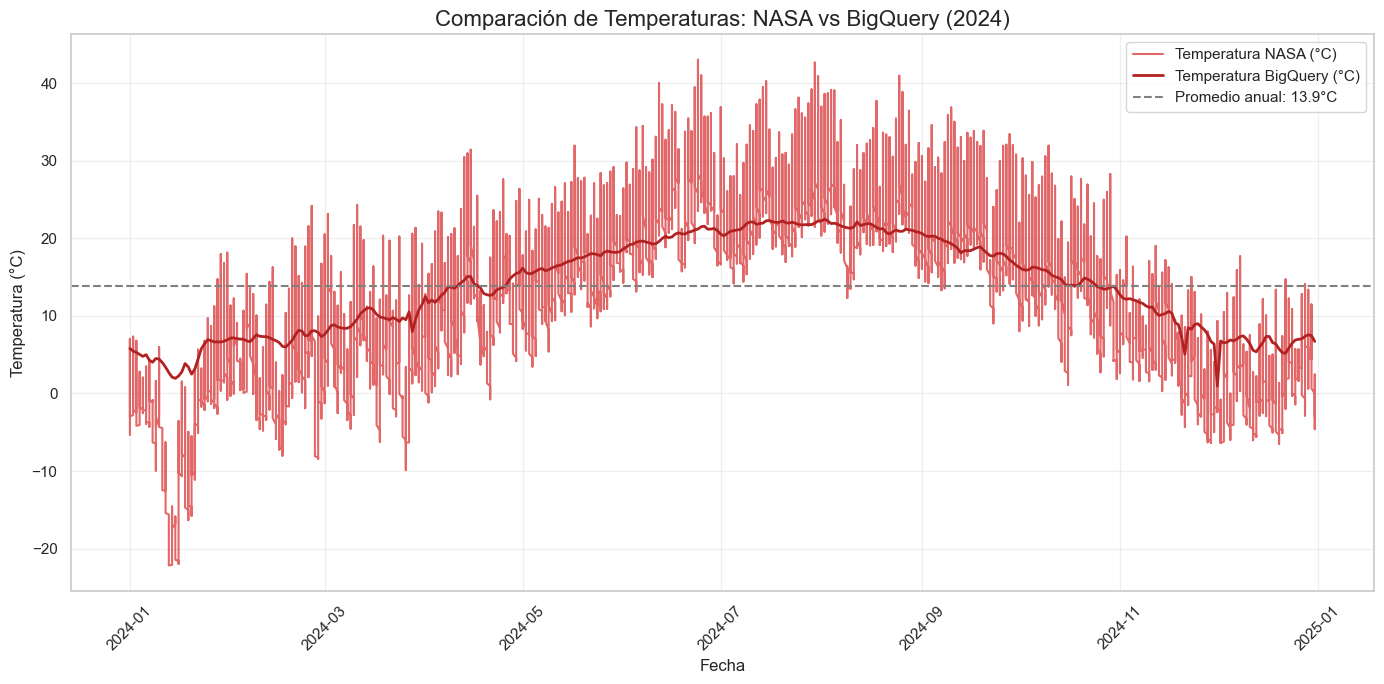

In [29]:
# Crear la figura y el eje
plt.figure(figsize=(14, 7))

# Primer gráfico (df)
plt.plot(df['fecha'], df['T2M'], 
         label='Temperatura NASA (°C)', 
         color='tab:red', 
         alpha=0.7)

# Segundo gráfico (df_bq_ordenado)
sns.lineplot(
    data=df_bq_ordenado, 
    x='Fecha', 
    y='Temperatura ºC', 
    estimator='mean', 
    errorbar=None,
    color='firebrick',
    label='Temperatura BigQuery (°C)',
    linewidth=2
)

# Línea de promedio anual
plt.axhline(y=promedio, 
            color='gray', 
            linestyle='--', 
            linewidth=1.5,
            label=f'Promedio anual: {promedio:.1f}°C')

# Personalización del gráfico combinado
plt.title('Comparación de Temperaturas: NASA vs BigQuery (2024)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()